# Lab 10: Homophily, Hits, Spectral Analysis

In this lab, we continue to explore a social network of legislators and the organizations that contribute to their campaigns.

The data is from [opensecrets.org](opensecrets.org), which collects public records about campaign finance in the United States.

We'll use `networkx`, a python package for social network analysis.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Reading in the data

In [2]:
df = pd.read_csv('legislators.csv',index_col=0)

In [3]:
get_leg_by_name = lambda name : df.loc[df['firstlast']==name]
get_leg_by_cid = lambda cid : df.loc[df['cid']==cid]

In [4]:
G = nx.read_gexf('contributions.xml')

In [5]:
leg_attr = lambda leg, attr : leg[attr].values[0]

# might break if two legislators have the same name
name_to_cid = lambda name : leg_attr(get_leg_by_name(name),'cid')

cid_to_name = lambda cid : leg_attr(get_leg_by_cid(cid),'firstlast')

In [6]:
leg_nodes = [node for node in G.nodes() if node in df['cid'].values]
contrib_nodes = [node for node in G.nodes if node not in leg_nodes]

In [7]:
big_contribs = [node for node in contrib_nodes if nx.degree(G,node)>=20]

## Projection

The legislator-contributor network is an example of an **affiliation network**. 

We can **project** across either set of nodes, inducing a network of legislators who share donors, or a network of contributors who donate to the same legislators. Let's now briefly investigate the projected legislator network.

In [8]:
G_leg = nx.projected_graph(G,leg_nodes)

Let's plot the degree distribution of this graph

In [9]:
degrees = {leg:nx.degree(G_leg,leg) for leg in leg_nodes}

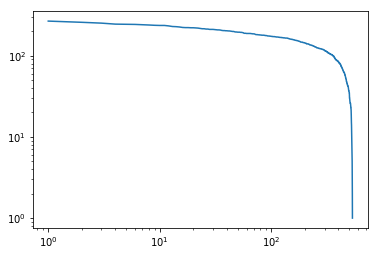

In [10]:
plt.loglog(sorted(degrees.values(),reverse=True));

Almost all nodes here have degree > 100. Definitely not a scale-free network.

## Homophily

The property of homophily is that individuals with similar properties tend to be connected.

In [13]:
parties = {row['cid']:row['party'] for _,row in df.iterrows()}

In [14]:
nx.set_node_attributes(G_leg,name='party',values=parties)

In [15]:
nx.attribute_mixing_dict(G_leg,'party')

{'D': {'D': 18764, 'I': 12, 'R': 12576},
 'I': {'D': 12, 'R': 3},
 'R': {'D': 12576, 'I': 3, 'R': 21942}}

This says: 

- 18764 links are between two democrats
- 21942 links are between two republicans
- $12576 \times 2$ links are between a democrat and republican

What is the probability of a mixing matrix like this arising by chance? We'll come back to this later.

In [16]:
#here's another view
M_party = nx.attribute_mixing_matrix(G_leg,'party')
print(M_party)

[[  3.33019670e-01   4.55318116e-05   1.90869354e-01]
 [  4.55318116e-05   0.00000000e+00   1.82127246e-04]
 [  1.90869354e-01   1.82127246e-04   2.84786304e-01]]


The trace of this matrix is the fraction of edges with the same value of the attribute.

In [50]:
observed_trace = M_party.trace()
print(observed_trace)

0.617805973774


**Your turn:** compute the same matrix for the state from which each legislators is from. The state is identified by the first two characters of the `office` attribute.

In [51]:
# your code here

The base probability of two nodes having the same attribute is $\theta = \sum_i P(i)^2$, summing over all possible values of the attribute. 

Under the null hypothesis, the trace of the attribute mixing matrix is drawn from a binomial distribution with parameters $(\theta, N)$, where $N$ is the total number of edges. Using this, we can compute $p$-values for these assortativity statistics.

In [19]:
M_party_counts = M_party * len(G_leg.edges())

In [20]:
M_party_counts.trace()

20353.0

In [21]:
from collections import Counter

In [22]:
party_counts = Counter(parties.values())
party_counts

Counter({'D': 234, 'I': 1, 'R': 304})

Now let's compute the base distribution over political parties.

In [42]:
p_party = np.array(list(party_counts.values()))/sum(party_counts.values())
p_party 

array([ 0.56400742,  0.43413729,  0.00185529])

The baseline chance of agreement is the sum of the squares:

In [46]:
p_agree = (p_party **2).sum()
p_agree

0.50658300088461761

**Your turn**: compute the same baseline agreement rate for states.

## Randomized test

Now let's try a shuffle test, to see if these extremely low $p$-values are plausible.

In [29]:
from random import shuffle

The node metadata is stored in a dict, `parties`. We're going to make the keys into a list, and repeatedly shuffle that list, thereby shuffling the assignment of parties to nodes in the network.

In [36]:
party_keys = list(parties.keys())

Here's how this looks:

In [37]:
for _ in range(5):
    shuffle(party_keys)
    print(party_keys[:5])

['N00002097', 'N00001102', 'N00034746', 'N00024922', 'N00035972']
['N00009759', 'N00031647', 'N00036409', 'N00025280', 'N00001813']
['N00012942', 'N00007360', 'N00001285', 'N00031877', 'N00033395']
['N00033474', 'N00007479', 'N00000743', 'N00033316', 'N00007360']
['N00003389', 'N00030829', 'N00027522', 'N00031177', 'N00000270']


Okay, let's do it. We'll store a list of traces of the mixing matrix, which is the null distribution over the fraction of edges in which both nodes have the same attribute.

In [38]:
traces = []
for _ in range(200):
    shuffle(party_keys)
    nx.set_node_attributes(G_leg,name='party',
                           values=
                           {party_keys[i]:parties[cid] for i,cid in enumerate(parties.keys())})
    traces.append(nx.attribute_mixing_matrix(G_leg,'party').trace())

In [52]:
print('P(agree) according to shuffle:',np.array(traces).mean())
print('P(agree), analytic:',p_agree)

P(agree) according to shuffle: 0.505405840214
P(agree), analytic: 0.506583000885


Very close! Now let's plot the null distribution.

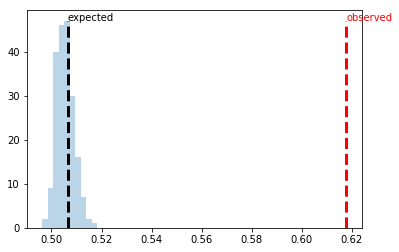

In [53]:
max_val = np.histogram(traces)[0].max()
plt.hist(traces,alpha=0.3);
# observed
plt.plot([observed_trace,observed_trace],[0,max_val],'r--',linewidth=3)
plt.text(observed_trace,max_val,'observed',color='r')
#analytical expectation
plt.plot([p_agree,p_agree],[0,max_val],'k--',linewidth=3)
plt.text(p_agree,max_val,'expected')
plt.axis('tight');

**Your turn** Do the same randomized test for states.

## Party assortativity, controlling for state

A potential confound is the state from which each legislator is from. Why is this a confound?

- The state might affect the *treatment*: whether two legislators are linked in the network. This is because some contributors focus on specific states.
- The state might affect the *outcome*: whether two legislators are from the same party.

To control for this, let's compute the same test, using only edges between legislators who are from the same state. We'll do this by iterating over the list of states, and focusing on the subgraph containing only these legislators.

In [125]:
# just in case this got shuffled
nx.set_node_attributes(G_leg,name='party',values=parties)

In [108]:
states = sorted(list(set([office[:2] for office in df['office']])))

In [110]:
print(states)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


Here's how we get a subgraph of all nodes in a single state.

In [129]:
the_locals = [node['cid'] for _,node in df.iterrows() if node['office'][:2] == 'GA']
print(the_locals)
G_state = G_leg.subgraph(the_locals)

['N00035346', 'N00002674', 'N00026163', 'N00027848', 'N00002577', 'N00026160', 'N00032416', 'N00032457', 'N00033518', 'N00032243', 'N00035347', 'N00033720', 'N00024871', 'N00030788', 'N00035516', 'N00002593']


Here's the trace of the mixing matrix for that subgraph

In [131]:
nx.attribute_mixing_matrix(G_state,'party').trace()

0.60824742268041232

Here are the raw counts, which is what we will aggregate when iterating over states

In [134]:
nx.attribute_mixing_dict(G_state,'party')

{'D': {'D': 12, 'R': 38}, 'R': {'D': 38, 'R': 106}}

Here are some helper functions for keeping track of these counts.

In [153]:
from collections import defaultdict

In [148]:
get_initial_counts = lambda : defaultdict(lambda : defaultdict(int))
def add_counts(counts1,counts2):
    for party1,row in counts2.items():
        for part2,count in row.items():
            counts1[party1][part2] += count
    return counts1

Here's how they work.

In [152]:
counts = get_initial_counts()
counts = add_counts(counts,nx.attribute_mixing_dict(G_state,'party'))
print(dict(counts))
counts = add_counts(counts,nx.attribute_mixing_dict(G_state,'party'))
print(dict(counts))

{'R': defaultdict(<class 'int'>, {'R': 106, 'D': 38}), 'D': defaultdict(<class 'int'>, {'R': 38, 'D': 12})}
{'R': defaultdict(<class 'int'>, {'R': 212, 'D': 76}), 'D': defaultdict(<class 'int'>, {'R': 76, 'D': 24})}


**Your turn** use these functions to fill in the function below, which should aggregate across states and compute the total mixing counts.

In [154]:
# your code here

In [157]:
counts = get_state_aggregated_mixing_counts(G_leg,df)

In [158]:
print(counts)

defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f78ad2febf8>, {'R': defaultdict(<class 'int'>, {'R': 1340, 'D': 675}), 'D': defaultdict(<class 'int'>, {'R': 675, 'D': 1396})})


Now we can compute the fraction of edges with the same party

In [167]:
def get_same_party_edges(counts):
    agree = counts['D']['D'] + counts['D']['R']
    disagree = counts['D']['R'] + counts['R']['D']
    return(agree/(agree+disagree))

In [168]:
observed_agreements_per_state = get_same_party_edges(counts)
print(observed_agreements_per_state)

0.6053785442852967


To build the randomized test, we must shuffle only edges within each state.

In [191]:
state_party_attrs = nx.get_node_attributes(G_state,'party')
keys = list(state_party_attrs.keys())
values = state_party_attrs.values()
for _ in range(3):
    shuffle(keys)
    nx.set_node_attributes(G_state,name='party',
                           values={keys[i]:parties[cid] for i,cid in enumerate(state_party_attrs.keys())})
    print(nx.attribute_mixing_dict(G_state,'party'))

{'D': {'R': 39, 'D': 12}, 'R': {'D': 39, 'R': 104}}
{'R': {'R': 110, 'D': 38}, 'D': {'R': 38, 'D': 8}}
{'D': {'D': 12, 'R': 40}, 'R': {'D': 40, 'R': 102}}


Let's incorporate this code into a randomized test

In [223]:
N_samples = 200
trace_counts = []
for i in range(N_samples):
    trace_counts.append(get_initial_counts())
for state in states:
    G_state = G_leg.subgraph([node['cid'] for _,node in df.iterrows() if node['office'][:2]==state])
    state_party_attrs = nx.get_node_attributes(G_state,'party')
    keys = list(state_party_attrs.keys())
    for i in range(N_samples):
        shuffle(keys)
        nx.set_node_attributes(G_state,name='party',
                               values={keys[i]:parties[cid] for i,cid in enumerate(state_party_attrs.keys())})
        state_counts = nx.attribute_mixing_dict(G_state,'party')
        trace_counts[i] = add_counts(trace_counts[i],state_counts)
    print(state,end=' ')

AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT WA WI WV WY 

In [224]:
samples = [get_same_party_edges(trace_count) for trace_count in trace_counts]

In [225]:
print(np.array(samples).mean())

0.546826952709


Not surprisingly, the null distribution is a little higher after controlling for the confound

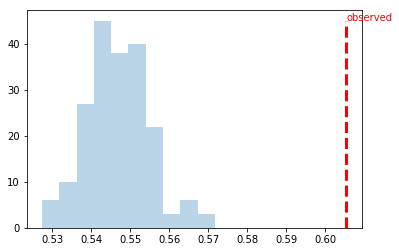

In [226]:
max_val = np.histogram(samples)[0].max()
plt.hist(samples,alpha=0.3);
# observed
plt.plot([observed_agreements_per_state,observed_agreements_per_state],[0,max_val],'r--',linewidth=3)
plt.text(observed_agreements_per_state,max_val,'observed',color='r')
plt.axis('tight');

But even after controlling for the confound of state membership, there's still significant assortativity by political party in the projected network.

## Hubs and authorities

Let's run the "Hubs and Authorities" algorithm from the reading on a directed network.

In [236]:
G2 = nx.DiGraph() #directed graph

In [266]:
for i,j in G.edges():
    if i in leg_nodes: #make sure the legislator is the first argument and the contributor is the second argument
        G2.add_edge(i,j)
    else:
        G2.add_edge(j,i)

In [267]:
[_ for _ in G2.edges()][:5]

[('N00003328', 'Biloxi Freezing & Processing'),
 ('N00003328', 'Tenax Aerospace'),
 ('N00003328', 'Huntington Ingalls Industries'),
 ('N00003328', 'Boeing Co'),
 ('N00003328', 'Votesane PAC')]

In [268]:
h,a = nx.hits(G2)

In [274]:
list(a.items())[:5]

[('N00003328', 0.0),
 ('Biloxi Freezing & Processing', 0.00014680144247484865),
 ('N00013855', 0.0),
 ('Fannie Mae', 0.00022628729059890232),
 ('N00025219', 0.0)]

Authorities are contributors, so legislators have zero values.

Who are the top contributors, according to this method?

In [1]:
contrib_df = pd.DataFrame({'authority':[a[node] for node in contrib_nodes],
                                 'name':contrib_nodes})

NameError: name 'pd' is not defined

In [301]:
contrib_df.loc[contrib_df['authority'].argsort()[::-1]][:10]

,authority,name
211,0.025076,American Crystal Sugar
952,0.023295,Intl Brotherhood of Electrical Workers
945,0.020308,Carpenters & Joiners Union
70,0.020183,Blue Cross/Blue Shield
20,0.020069,American Federation of Teachers
1077,0.019292,AT&T Inc
230,0.019276,Boeing Co
502,0.018680,Machinists/Aerospace Workers Union
1802,0.014333,Honeywell International
649,0.012064,Comcast Corp


## Spectral clustering

Spectral clustering is a technique for clustering data based on a matrix of similarity scores between instances. We can use the adjacency matrix of the graph over legislators.

The first step is to compute the normalized Laplacian. We saw the Laplacian in class, $L = D - A$, where $D$ is the diagonal degree matrix.

In [367]:
nx.normalized_laplacian_matrix(G_leg)

<537x537 sparse matrix of type '<class 'numpy.float64'>'
	with 66423 stored elements in Compressed Sparse Row format>

In [397]:
# need this for sparse linear algebra
from scipy.sparse import linalg

The clustering is based on the eigenvector with the second-smallest eigenvalue.

`which='SM'` tells the algorithm to return the smallest magnitude eigenvalues.

In [399]:
vals, vecs = linalg.eigs(nx.normalized_laplacian_matrix(G_leg),which='SM')
vecs = vecs.astype('f')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [400]:
node_idxs = list(G_leg.nodes())

Let's see if the associated eigenvectors distinguish the legislators by political party.

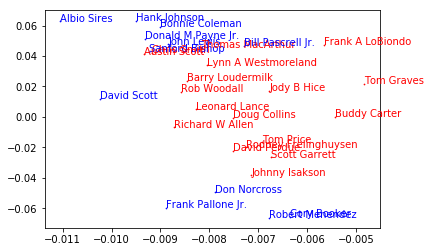

In [409]:
for cid in leg_nodes:
    leg = get_leg_by_cid(cid)
    if leg_attr(leg,'office')[:2] == 'GA' or leg_attr(leg,'office')[:2] == 'NJ':
        idx = node_idxs.index(cid)
        color = 'g'
        if leg_attr(leg,'party') == 'D':
            color = 'b'
        elif leg_attr(leg,'party') == 'R':
            color='r'
        plt.scatter(vecs[idx,0],vecs[idx,1],.5,color=color)
        plt.text(vecs[idx,0],vecs[idx,1],leg_attr(leg,'firstlast'),color=color)
#plt.axis('tight');

Not perfect, but pretty good.

**Your turn**: try some other states and see if it still works.

**Your turn**: can you see how to make the same sort of figure for the contributors?